In [33]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from training import *
from models import *
from A2C_agent import *
from helpers import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
device = device_selection() # mps -> cuda -> cpu

# Initialize environment
env = gym.make('CartPole-v1') 

# hyperparameters
batch_size = 256
gamma_ = 0.99
lr_actor = 1e-5
lr_critic = 1e-3
eps = 0.2
num_workers=1
num_episodes = 10000
total_steps_budget = 500000
max_steps_per_episode = 1000

# neural network structure
input_size = env.observation_space.shape[0] # 4
hidden_size = 64
output_size_actor = env.action_space.n # 2
output_size_critic = 1

critic_losses = []
actor_losses = []
episode_rewards = []


# Initialize agent 
agent = Agent(input_size, hidden_size, \
                output_size_actor, output_size_critic, \
                eps, gamma_, lr_actor, lr_critic, num_workers, \
                device=device)

# Initialize batch
batch = []

for episode in range(num_episodes):
    state, _ = env.reset()
    state = torch.from_numpy(state).float().to(device)  # Convert state to a tensor

    episode_reward = 0

    for t in range(max_steps_per_episode):
        action = agent.select_action(state, worker_id=0, policy="eps-greedy")
        next_state, reward, terminated, truncated, _ = env.step(action.item())
        agent.num_steps += 1
        
        next_state = torch.from_numpy(next_state).float().to(device)  # Convert next_state to a tensor
        done = terminated or truncated
        episode_reward += reward

        # Add the experience to the batch
        batch.append((state, action, reward, next_state, done))

        if len(batch) >= batch_size or done:
            # this line is to make batch compatible with the training. 
            # Should be a dict with keys as worker_ids when num_workers>1
            batches_dict = {0: batch}
            # Train the agent
            critic_loss, actor_loss = agent.train(batches_dict, agent.gamma, agent.lr_actor, agent.lr_critic, agent.device)
            
            critic_losses.append(critic_loss)
            actor_losses.append(actor_loss)
            episode_rewards.append(episode_reward)
            # Clear the batch
            batch.clear()

        state = next_state
        if done: break

    if episode % 100 == 0:
        print(f"Episode {episode} finished after {t+1} steps with reward {episode_reward:.2f}")
        print(f"Actor loss: {actor_loss:.2f}, Critic loss: {critic_loss:.2f}",f"  Total steps: {agent.num_steps}")
        print("--------------------------------------------------")
    
    if (agent.num_steps >= total_steps_budget): 
        print(f"Reached total training budget of {total_steps_budget} steps ----> Stopping training at episode {episode}")
        break

agent.training_done()
agent.save("./A2C_cartpole")


Episode 0 finished after 12 steps with reward 12.00
Actor loss: -0.64, Critic loss: 0.97   Total steps: 12
--------------------------------------------------
Episode 100 finished after 11 steps with reward 11.00
Actor loss: -0.52, Critic loss: 1.94   Total steps: 1193
--------------------------------------------------
Episode 200 finished after 14 steps with reward 14.00
Actor loss: -0.40, Critic loss: 5.64   Total steps: 2505
--------------------------------------------------
Episode 300 finished after 12 steps with reward 12.00
Actor loss: -0.16, Critic loss: 12.37   Total steps: 3883
--------------------------------------------------
Episode 400 finished after 17 steps with reward 17.00
Actor loss: -0.16, Critic loss: 8.50   Total steps: 5303
--------------------------------------------------
Episode 500 finished after 15 steps with reward 15.00
Actor loss: -0.06, Critic loss: 6.64   Total steps: 6669
--------------------------------------------------
Episode 600 finished after 17 s

# TO IMPLEMENT
- parallel workers
- a method for batch formation?

workers all use the same parameters and get updated with the same gradient at the same time (if not at the same time --> updates with different policies by definition, but A2C is on-policy). Doesn't matter if they (inevitably) end episodes at different time-steps. What matters is they have the same policy when accumulating a batch (same actor-critic params).

batches vanilla are (1x1), in general (num_time_steps x num_workers)

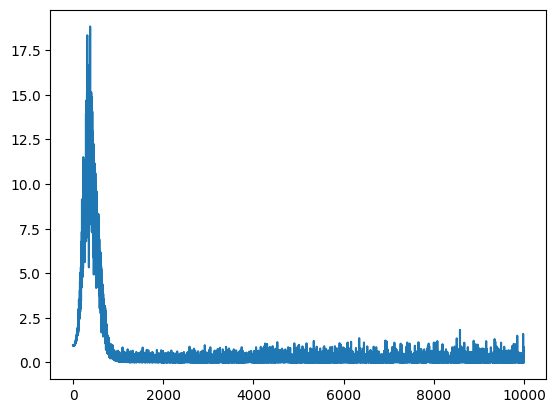

In [35]:
plt.plot(critic_losses)

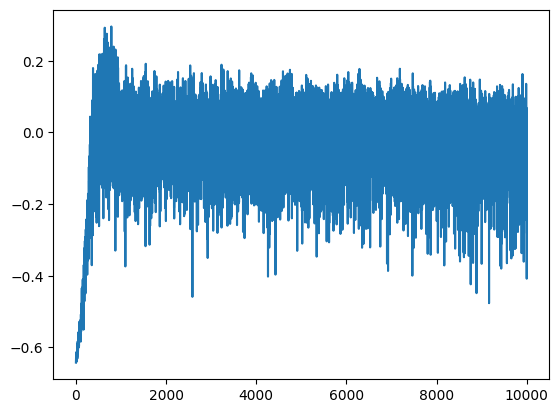

In [36]:
plt.plot(actor_losses)

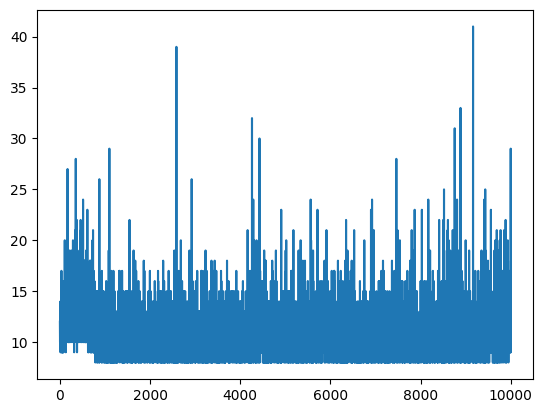

In [37]:
plt.plot(episode_rewards)